In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from timeparser import TimeParser
from weather_predictor import WeatherPredictor

/Users/vasileiosmermiklis/Documents/ML-assignment/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('wheather_data.csv')
df = df.sample(frac=1)
df.head()

,id,timestamp,value,identifier,value_type_id,location_id,source_id
211980,5776321,2019-07-12 00:03:45,0.00,UVI,40,23.0,5
187670,5671136,2019-07-09 00:02:52,0.00,P,37,30.0,5
367871,6295766,2019-07-25 12:00:14,1014.89,PMSL,64,27.0,10
198147,5723652,2019-07-10 18:20:06,28.00,T,11,116.0,5
182205,5632818,2019-07-08 02:20:08,1007.10,PMSL,55,30.0,5


In [3]:
df = df.drop(columns=["id"])
print("Number of NaN values:")
df.isna().sum()

Number of NaN values:


timestamp        0
value            0
identifier       0
value_type_id    0
location_id      0
source_id        0
dtype: int64

In [4]:
# Min, max of timestamps
print(f'Min time: {df["timestamp"].min()}, max time: {df["timestamp"].max()}')
# Min, max, count of numerical columns
df[["value"]].describe().loc[["min", "mean", "max"]]

Min time: 2019-04-25 13:20:09, max time: 2019-07-29 23:40:08


,value
min,-0.01900
mean,153.45302
max,1021.90000


(!) Even though IDs are numbers, they are categorical data since they do not have numeric relationship to one another

In [5]:
# Find unique values and their frequencies
df_cat = df[["identifier", "value_type_id", "location_id", "source_id"]]
frequencies = {c: df[c].value_counts() for c in df_cat.columns}
# Indicative examples
print(frequencies["location_id"])
print(frequencies["source_id"])

location_id
30.0     128465
23.0     126003
27.0      96668
116.0     55563
152.0        20
Name: count, dtype: int64
source_id
5     313387
10     52320
6      41012
Name: count, dtype: int64


After some data exploration, I noticed there is a duplicate `value_type_id`

In [6]:
# The unique combinations of identifier and value_type_id
unique_combos = df[["identifier", "value_type_id"]].drop_duplicates()
# Find the value_type_id that corresponds to multiple identifiers
duplicated_index = np.argwhere(unique_combos["value_type_id"].duplicated())[0, 0]
duplicated_value_id = unique_combos.iloc[duplicated_index]['value_type_id']
print("Duplicate value_type_id:")
print(unique_combos[unique_combos["value_type_id"] == duplicated_value_id])

Duplicate value_type_id:
                  identifier  value_type_id
220207                  PMSL             27
195923  pressureMeanSeaLevel             27


In [7]:
# Change all "pressureMeanSeaLevel" occurrences to "PMSL"
df["identifier"] = df["identifier"].apply(
    lambda x: "PMSL" if x == "pressureMeanSeaLevel" else x
)

We can see that each `value_type_id` corresponds to exactly one `source_id`. Therefore, the `source_id` does not provide any information.

In [8]:
multi_source_types = [] # The value_types that correspond to more than one source
for i in df["value_type_id"].unique():
    if len(df[df["value_type_id"] == i]["source_id"].unique()) != 1:
        multi_source_types.append(i)
print(multi_source_types)

[]


In [9]:
# Remove the source_id column, because it does not provide information
df = df.drop(["source_id"], axis=1)
df.head()

,timestamp,value,identifier,value_type_id,location_id
211980,2019-07-12 00:03:45,0.00,UVI,40,23.0
187670,2019-07-09 00:02:52,0.00,P,37,30.0
367871,2019-07-25 12:00:14,1014.89,PMSL,64,27.0
198147,2019-07-10 18:20:06,28.00,T,11,116.0
182205,2019-07-08 02:20:08,1007.10,PMSL,55,30.0


Each `identifier` can have multiple `value_type_id`s. Each of its `value_type_id`s can show great variance in its `value`s. This means we should use `value_type_id` as the input feature.

In [10]:
# Show the variance of different value_type_ids for temperature
df[df["identifier"] == "T"][["value_type_id", "value"]].groupby("value_type_id").min()

,value
value_type_id,
11,6.00
21,287.94
39,14.40
57,15.40


In [11]:
# Remove the identifier column, because value_type_id will be used
df = df.drop(["identifier"], axis=1)

In [12]:
df.head()

,timestamp,value,value_type_id,location_id
211980,2019-07-12 00:03:45,0.00,40,23.0
187670,2019-07-09 00:02:52,0.00,37,30.0
367871,2019-07-25 12:00:14,1014.89,64,27.0
198147,2019-07-10 18:20:06,28.00,11,116.0
182205,2019-07-08 02:20:08,1007.10,55,30.0


In [13]:
# Convert the timestamps into a readable format for the ANN
timeseries = df["timestamp"]
tp = TimeParser(hours_per_slot=2)
encoded_timeseries = tp.fit_transform(timeseries)
encoded_timeseries.head()

,Season_0,Season_1,Season_2,Season_3,Season_4,Season_5,Season_6,Slot_0,Slot_1,Slot_2,Slot_3,Slot_4,Slot_5,Slot_6,Slot_7,Slot_8,Slot_9,Slot_10,Slot_11
0,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False


Now, since `value_type_id` and `location_id` are discrete, categorical data, they should be one-hot-encoded.

In [14]:
df_cat = df[["value_type_id", "location_id"]]

In [15]:
enc = OneHotEncoder()
encoded_cat = enc.fit_transform(df_cat)
encoded_cat = encoded_cat.toarray()

In [16]:
# Create the input array
X = np.concatenate((encoded_timeseries, encoded_cat), axis=1)

`y` should be scaled for better performance. Based on `value_type_id`, some `value`s are much higher than others and they have different variances. We will apply z-score normalization **per `value_type_id`**, meaning that different means and variances will be computed for different `value_type_id`s.

In [17]:
scale_map = df.groupby("value_type_id")["value"].agg(["mean", "std"]).rename(columns={"mean": "mu", "std": "sigma"})
df = df.join(scale_map, on="value_type_id")
y = np.expand_dims(np.array((df["value"] - df["mu"]) / df["sigma"]), axis=1)
scale_params = df[["sigma", "mu"]]
X.shape, y.shape

((406719, 71), (406719, 1))

For the same `value_type_id`s, `location_id`s and `timestamp`s there are multiple observations from the sensors. This adds noise to our data and makes the prediction harder. For each combination above, the mean value will be calculated and duplicates will be removed.

In [18]:
X_unique, unique_indices, inverse_indices = np.unique(X, axis=0, return_index=True, return_inverse=True)
y_unique = np.array([y[inverse_indices == i].mean() for i in range(len(X_unique))])
y_unique = np.expand_dims(y_unique, axis=1)
X_unique.shape, y_unique.shape

((4795, 71), (4795, 1))

In [19]:
wp = WeatherPredictor(
    X_unique, y_unique, scale_params.iloc[unique_indices], [256] * 5, "relu", "mae", "adam",
)
history = wp.fit(epochs=60)

Epoch 1/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4839 - val_loss: 0.3951
Epoch 2/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3505 - val_loss: 0.3343
Epoch 3/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2507 - val_loss: 0.2684
Epoch 4/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2120 - val_loss: 0.2281
Epoch 5/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1749 - val_loss: 0.2089
Epoch 6/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1490 - val_loss: 0.1843
Epoch 7/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1291 - val_loss: 0.1738
Epoch 8/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1205 - val_loss: 0.1741
Epoch 9/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1125 - val_loss: 0.1618
Epoch 10/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1092 - val_loss: 0.1505
Epoch 11/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1002 - val_loss: 0.1487
Epoch 12/60
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

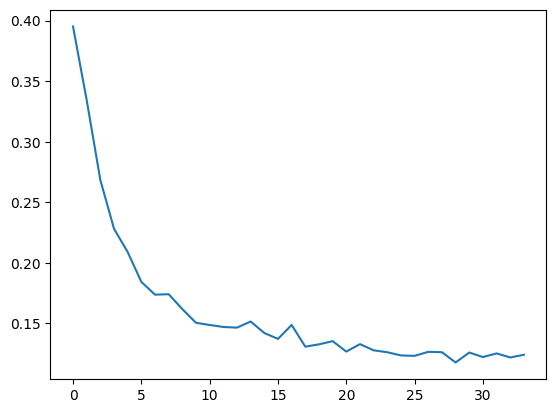

In [20]:
plt.plot(history.history["val_loss"])
plt.show()

Now, let's calculate the mean absolute error for the predictions of the validation data on their original scale.

In [21]:
y_pred = wp.predict(wp.x_val)
y_pred_unscaled = y_pred * np.expand_dims(np.array(wp.scale_params_val["sigma"]), axis=1) + np.expand_dims(np.array(wp.scale_params_val["mu"]), axis=1)
y_val_unscaled = wp.y_val * np.expand_dims(np.array(wp.scale_params_val["sigma"]), axis=1) + np.expand_dims(np.array(wp.scale_params_val["mu"]), axis=1)
error = np.abs(y_pred_unscaled - y_val_unscaled)
float(error.mean())

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2.6647777576342544

In [22]:
sort_indices = np.argsort(wp.y_val[:, 0])
y_pred_unscaled = y_pred_unscaled[sort_indices]
y_pred = y_pred[sort_indices]
y_val = wp.y_val[sort_indices]
y_val_unscaled = y_val_unscaled[sort_indices]

Let's show the predictions for the validation data, sorted by the true values.

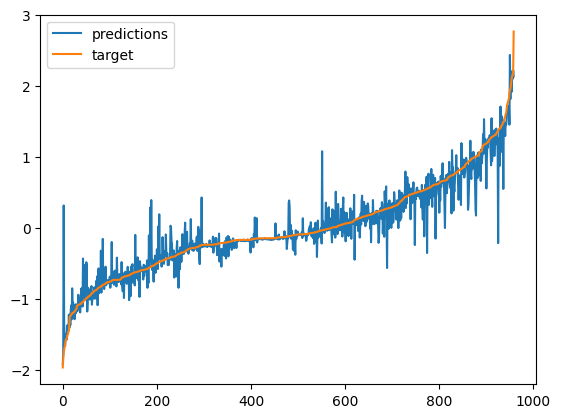

In [23]:
plt.plot(y_pred[:, 0], label="predictions")
plt.plot(y_val[:, 0], label="target")
plt.legend()
plt.show()